# Imports

In [15]:
import pandas as pd
from pathlib import Path
import os
import plotly.express as px
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import seaborn


# Obtenção dos dados

In [6]:
# Listar arquivos no diretório acima
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'Pre-processamento'

file_path_raw = base_path / 'dataset_cotton_fruit.xlsx'
file_path_msc = base_path / 'data_msc.xlsx'
file_path_snv = base_path / 'data_snv.xlsx'
file_path_sg = base_path / 'data_savgol_ordem_1.xlsx'

df_raw = pd.read_excel(file_path_raw)
df_msc = pd.read_excel(file_path_msc)
df_snv = pd.read_excel(file_path_snv)
df_sg = pd.read_excel(file_path_sg)


# PLSR

In [33]:
X_waves = df_msc.values

In [31]:
def optimise_pls_cv(X, y, n_comp, plot_components=True, nome_col=None):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
       
    # Mean centering
    X_mean = np.mean(X, axis=0)
    X -= X_mean
 
    # Define the parameter space for the search. Just the number of LV here
    parameters = {'n_components': np.arange(1, n_comp, 1)}
    
    # Define the grid-search estimator based on PLS regression
    pls = GridSearchCV(PLSRegression(), parameters, scoring='neg_mean_squared_error', verbose=0, cv=10)
    
    # Fit the estimator to the data
    pls.fit(X, y)
    
    # Optional: print the best estimator
    print(pls.best_estimator_)
    
    # Apply the best estimator to calculate a cross-validation predicted variable
    y_cv = cross_val_predict(pls.best_estimator_, X, y, cv=10)
    
    # Optional: calculate figures of merit
    rmse, score = np.sqrt(mean_squared_error(y, y_cv)), r2_score(y, y_cv)
 
    # Calculate scores for calibration and cross-validation
    y_c = pls.predict(X)  # Predicted variable from calibration
    
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    
    # Calculate root mean squared error for calibration and cross validation
    rmse_c = np.sqrt(mse_c)
    rmse_cv = np.sqrt(mse_cv)

    # Calculate bias for calibration and cross validation
    bias_c = np.mean(y - y_c)
    bias_cv = np.mean(y - y_cv)

    # Calculate RPD for cross validation
    rpd_cv = np.std(y) / rmse_cv
 
    print('R2 calib: %5.6f' % score_c)
    print('R2 CV: %5.6f' % score_cv)
    print('RMSE calib: %5.6f' % rmse_c)
    print('RMSE CV: %5.6f' % rmse_cv)
    print('Bias calib: %5.6f' % bias_c)
    print('Bias CV: %5.6f' % bias_cv)
    print('RPD CV: %5.6f' % rpd_cv)
 
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
    
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        z = np.polyfit(y, y_c, 1)
        ax.plot(np.polyval(z, y), y, c='blue', linewidth=1)
        ax.plot(y, y, color='green', linewidth=1)
        plt.title(f'{nome_col}\n$R^{2}$ (CV): {score_cv}')
        plt.xlabel('Predicted')
        plt.ylabel('Measured')
        
        plt.show()

    fig = px.scatter(x=y, y=y_cv.flatten(), trendline="ols", width=600, height=600,\
                labels = {"x":"Measured", "y":"Predicted"})
    fig.show()
 
    return


PLSRegression(n_components=14)
R2 calib: 0.904113
R2 CV: 0.791893
RMSE calib: 0.775258
RMSE CV: 1.142113
Bias calib: -0.000000
Bias CV: 0.032107
RPD CV: 2.192084


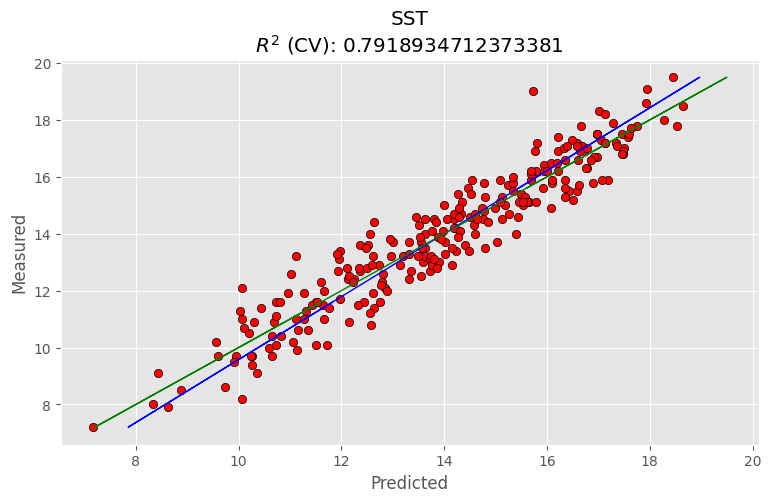

In [34]:
optimise_pls_cv(X_waves,df_raw['SST'].values,40, True, 'SST')

PLSRegression(n_components=21)
R2 calib: 0.921271
R2 CV: 0.484849
RMSE calib: 0.075194
RMSE CV: 0.192348
Bias calib: 0.000000
Bias CV: 0.010610
RPD CV: 1.393262


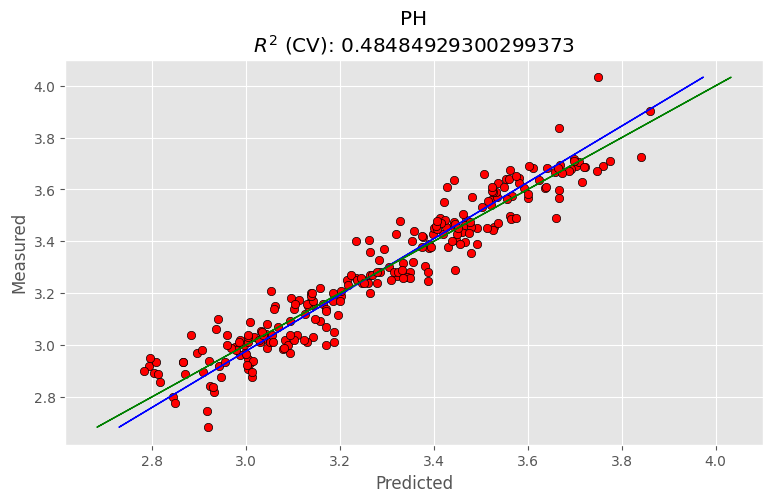

In [35]:
optimise_pls_cv(X_waves,df_raw['PH'].values,40, True, 'PH')